# Straddle and spread options portfolio

In his note we consider options portfolios known as straddle and spread, and approaches to computing their payoff distributions. Approaches to computing payoff distribution include

<ul>
<li>Historic simulation</li>
<li>Monte Carlo simulation</li>
<li>Analytic Delta method</li>
</ul>

## Import some tools

In [1]:
import datetime as dt
import pandas as pd
import options_classes as ocl
from scipy.stats import norm
labels = ocl.make_label_dict()
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Payoffs

### Options

Let $K$ be the option strike price, and $S$ denote the underlying price. If call option price is $c$, and put option price is $p$ (all prices discounted to present time), then payoff functions of long call and put options are

$$
C(S)=\max(0,S-K)-c=(S-K)_+-c,\;\;\;P(S)=\max(0,K-S)-p=(K-S)_+-p.
$$

Payoff of a short position equals to the negative payoff of the corresponding long position.

### Straddle portfolio

This portfolio includes a call and a put options with the same underlying, strike price and maturity. Thus payoff of the portfolio equals

$$ T = |K-S|-c-p. $$

Payoff is depicted in the figure below.

### Bull spread portfolio

This portfolio consists of a long position in in-the-money call option, with strike price $K_l<S_0$, and a short position in out-of the money call, with strike price $K_s > S_0$, where $S_0$ stands for the current price of the underlying asset. Its payoff equals

$$
BuS(S) = (S-K_l)_+-(S-K_s)_+ - c_l + c_s,
$$

where $c_l, c_s$ stand for call prices with strike prices $K_l, K_s$ respectively.

### Bear spread portfolio

This portfolio is opposite to bull spread, it consists of a short position in in-the-money call option, with strike price $K_l<S_0$, and a long position in out-of the money call, with strike price $K_s > S_0$, where $S_0$ stands for the current price of the underlying asset. Its payoff equals

$$
BeS(S) = -(S-K_l)_++(S-K_s)_+ + c_l - c_s = -BuS(s),
$$

where $c_l, c_s$ stand for call prices with strike prices $K_l, K_s$ respectively.

## Plotting functions

In [2]:
def straddle_plot(k=100, s0=100, rf=0.01, vol=0.15,
                          cur_dat='2017-08-14',
                          dat='2017-12-01', fig_name='fig_1_a'):
    """ """
    bu = ocl.straddle(k)
    s_wid = 20
    s = np.linspace(s0 - s_wid, s0 + s_wid, 101)    # future asset price
    po = bu.payoff(s0, s, vol, rf, cur_dat, dat)
    po.plot()
    pd.Series(0, index=po.index).plot()
    # plot labels and title
    xlabel(ocl.asset_price)
    ylabel(ocl.payoff)
    tit = '{0}, {1}'.format(ocl.straddle_payoff, dat)
    ti = title(tit)
    # saving to CSV file
    df = pd.DataFrame(po, columns=['value'])
    df['zero'] = 0
    fn = 'csv/{0}.csv'.format(fig_name)
    df.to_csv(fn, index=None)

In [3]:
def bull_spread_plot(kl=90, ks=110, s0=100, rf=0.01, vol=0.15,
                     cur_dat='2017-08-14',
                     dat='2017-12-01', fig_name='fig_1_c', mult=1):
    """ """
    bu = ocl.bull_spread(kl, ks)
    s_wid = 20
    s = np.linspace(s0 - s_wid, s0 + s_wid, 101)    # future asset price
    po = bu.payoff(s0, s, vol, rf, cur_dat, dat)
    (mult * po).plot()
    pd.Series(0, index=po.index).plot()
    # plot labels and title
    xlabel(ocl.asset_price)
    ylabel(ocl.payoff)
    tit = '{0}, {1}, Kl={2}, Ks={3}'.format(ocl.bull_spread_payoff if mult == 1 else ocl.bear_spread_payoff, dat, kl, ks)
    ti = title(tit)
    # saving to CSV file
    df = pd.DataFrame(po, columns=['value'])
    df['zero'] = 0
    fn = 'csv/{0}.csv'.format(fig_name)
    df.to_csv(fn, index=None)

## Payoff plots

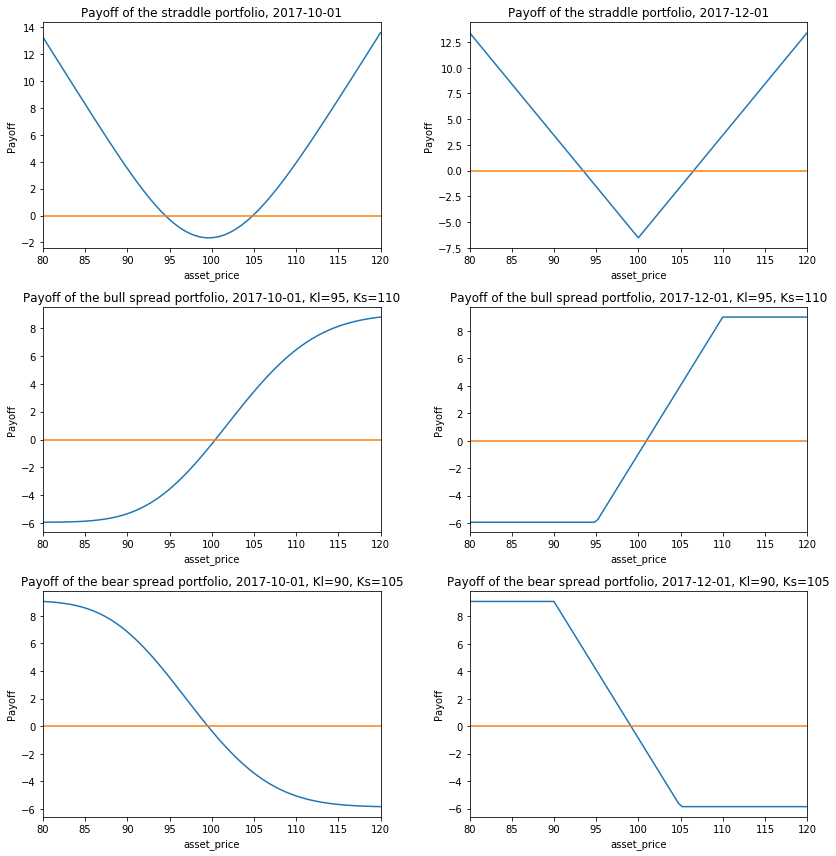

In [4]:
figsize(12, 12)                                      # figure size
subplot(3, 2, 1)
straddle_plot(dat='2017-10-01', fig_name='fig_1_a')
subplot(3, 2, 2)
straddle_plot(dat='2017-12-01', fig_name='fig_1_b')
subplot(3, 2, 3)
bull_spread_plot(kl=95, ks=110, dat='2017-10-01', fig_name='fig_1_c')
subplot(3, 2, 4)
bull_spread_plot(kl=95, ks=110, dat='2017-12-01', fig_name='fig_1_d')
subplot(3, 2, 5)
bull_spread_plot(kl=90, ks=105, dat='2017-10-01', mult=-1, fig_name='fig_1_e')
subplot(3, 2, 6)
bull_spread_plot(kl=90, ks=105, dat='2017-12-01', mult=-1, fig_name='fig_1_f')
tight_layout()
savefig('images/fig_1.png')

## Code

In [5]:
# global variables
rf = 0.01

# describe current underlying state
snp500 = 2300

### Generic procedure

In [6]:
def simulate_it(hist=True, typ='straddle', fig_name='fig_2'):
    """ generic simulation procedure """
    # read the S&P 500 data
    snp = ocl.SnP500_data()

    # last date values as a start for forecasting
    snp500 = snp.last_value()

    # use mean annual volatility for 5 last years as a model volatility parameter
    vol = snp.annual_vols().tail().mean()[0]

    # spread for butterfly strikes
    spr = snp500 * vol

    # multiple for spread
    mult = 0.5

    # strikes and dates
    K = snp500
    wid = K * 0.15
    Kl, Ks = K - wid, K + wid
    exp_dat = '2017-12-01'
    cur_dat = '2017-04-01'

    # calls straddle portfolio
    if typ == 'straddle':
        buc = ocl.straddle(K, expir=exp_dat)
    elif typ == 'bull':
        buc = ocl.bull_spread(Kl, Ks, expir=exp_dat)
    else:
        buc = ocl.bull_spread(Kl, Ks, expir=exp_dat, vlm=-1)

    # calculation dates
    calc_dats = ['2017-09-01','2017-10-01','2017-11-01','2017-12-01']

    # output dataframe templates
    dfo = pd.DataFrame()
    n_paths = 5000
    dfe = pd.DataFrame(index=range(n_paths))

    # two plots in one figure
    figsize(12,4)
    
    # suffix in file names
    suff = 'hist' if hist else 'MC'

    # first plot
    subplot(1,2,1)
    for calc_dat in calc_dats:
        # dates difference in calendar and business days
        tot_days = (pd.to_datetime(calc_dat) - pd.to_datetime(cur_dat)).days
        bus_days = int(tot_days / 365 * 250)
    
        if hist:
            # simulate S&P500 values using historic method
            s = snp500 * snp.make_hist_returns(n_paths=n_paths, n_days=bus_days)[-1, :]
        else:
            s = snp500 * snp.make_mc_returns(n_paths=n_paths, n_days=bus_days)[-1, :]
    
        # portfolio payoff for all simulates snp500 values
        po = buc.payoff(snp500, s, vol, rf, cur_dat, calc_dat)
        po.name = ocl.port_payoff_lab
    
        # keep descriptive stats for simulated payoffs
        dfo[calc_dat] = po.describe([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
    
        # plot empiric CDF for simulated payoffs
        poe = ocl.ecdf(po)
        poe.plot(label=calc_dat)
        dfe[calc_dat] = np.array(poe)
        #poe.round(3).to_csv('csv/{0}_a.csv'.format(fig_name), header=True)
    ti = title(ocl.port_payoff_tit)
    le = legend()
    #dfe.index.name = ''
    dfe.round(3).to_csv('csv/{0}_a.csv'.format(fig_name), index=None)

    # now plot the percentiles of payoffs vs the calc date
    dfd = dfo.T.round(3)
    dfd.index.name = 'date'
    prc = ['50%','75%','90%','95%']
    subplot(1,2,2)
    for pr in prc:
        dfd[pr].plot(label=pr)
    ti = title(ocl.port_perc_tit)
    le = legend()
    savefig('images/{0}.png'.format(fig_name))
    dfd.round(3).to_csv('csv/{0}_b.csv'.format(fig_name))

## Distribution of straddle payoff

### Historic simulation

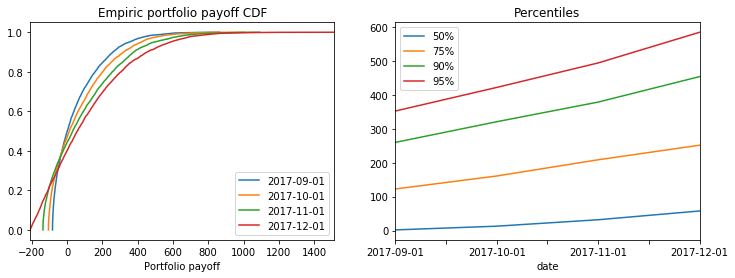

In [7]:
simulate_it(hist=True, typ='straddle', fig_name='fig_2')

### Monte Carlo simulation

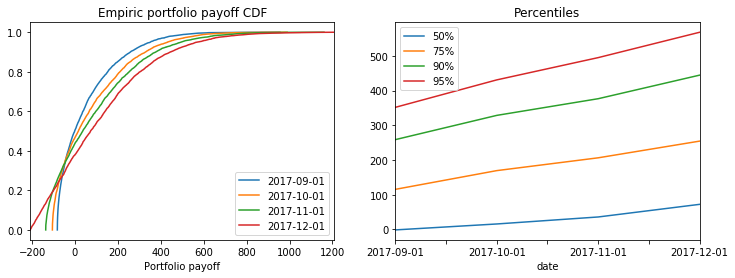

In [8]:
simulate_it(hist=False, typ='straddle', fig_name='fig_3')

We see that distributions from historic and Monte Carlo simulations are essencially the same. This is due to the fact that S&P 500 index is a weighted average of many stocks behavior, so distribution of its returns is rather close to Gaussian.

## Distribution of bull spread payoff

### Historic simulation

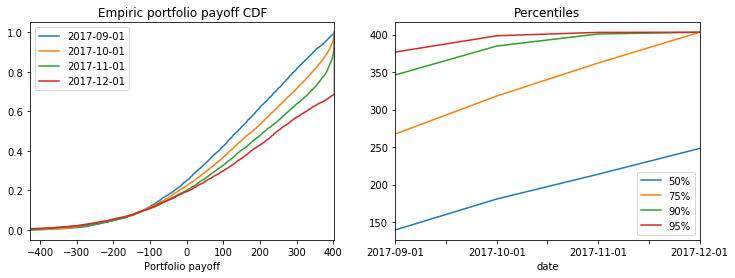

In [9]:
simulate_it(hist=True, typ='bull', fig_name='fig_4')

### Monte Carlo simulation

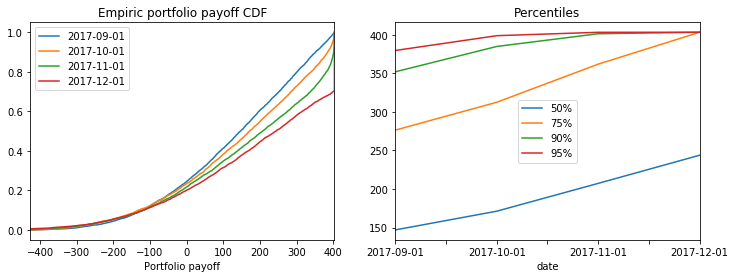

In [10]:
simulate_it(hist=False, typ='bull', fig_name='fig_5')

## Distribution of portfolio value at a given horizon

Let's compare distribution of future portfolio value, calculated by three methods: Delta method, historic simulation and Monte Carlo simulation.

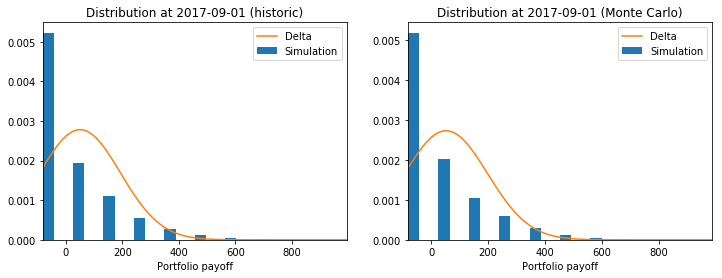

In [11]:
def norm_dens_for(po, nn=101):
    """ normal density for the series po """
    de = po.describe()
    me, st, mi, ma = de['mean'], de['std'], de['min'], de['max']
    xx = np.linspace(mi, ma, nn)
    yy = norm.pdf(xx, me, st)
    return pd.Series(yy, index=xx)

def fin_distr(calc_dat='2017-09-01'):
    """ butterfly portfolio distribution as of future calc_dat """
    # read the S&P 500 data
    snp = ocl.SnP500_data()

    # last date values as a start for forecasting
    snp500 = snp.last_value()

    # use mean annual volatility for 5 last years as a model volatility parameter
    vol = snp.annual_vols().tail().mean()[0]

    # spread for butterfly strikes
    spr = snp500 * vol

    # multiple for spread
    mult = 0.5

    # strikes and dates
    K = snp500
    exp_dat = '2017-12-01'
    cur_dat = '2017-04-01'

    # calls butterfly portfolio
    buc = ocl.straddle(K, expir=exp_dat)

    tot_days = (pd.to_datetime(calc_dat) - pd.to_datetime(cur_dat)).days
    bus_days = int(tot_days / 365 * 250)
    hor = tot_days / 365          # horizon in years
    
    # simulate S&P500 values using historic and Monte Carlo methods
    s_hist = snp500 * snp.make_hist_returns(n_paths=5000, n_days=bus_days)[-1, :]
    s_mc = snp500 * snp.make_mc_returns(n_paths=5000, n_days=bus_days)[-1, :]
    
    # volatility in a horizon period
    vol_hor = vol * sqrt(hor)
    
    # portfolio payoff for all simulated snp500 values
    po_hist = buc.payoff(snp500, s_hist, vol, rf, cur_dat, calc_dat)
    po_hist.name = ocl.port_payoff_lab
    po_mc = buc.payoff(snp500, s_mc, vol, rf, cur_dat, calc_dat)
    po_mc.name = ocl.port_payoff_lab
    
    figsize(12,4)
    subplot(1,2,1)
    po_hist.hist(width=40, normed=True, label=ocl.simul_lab)
    se = norm_dens_for(po_hist)
    se.plot(label=ocl.delta_lab)
    xlabel(ocl.port_payoff_lab)
    title(ocl.distr_hist_tit.format(calc_dat))
    legend()
    subplot(1,2,2)
    po_mc.hist(width=40, normed=True, label=ocl.simul_lab)
    se = norm_dens_for(po_mc)
    se.plot(label=ocl.delta_lab)
    xlabel(ocl.port_payoff_lab)
    title(ocl.distr_mc_tit.format(calc_dat))
    legend()
fin_distr()